## Importing data from Yahoo finance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
yf.__version__

'0.1.85'

In [3]:
tickers = ['AMZN','AAPL','BRK-A','XOM','MSFT','TSLA','UNH']

In [4]:
data = yf.download(tickers, start="2017-11-14",end="2022-11-14")
prices = data['Adj Close']
prices.tail()

#putting stock prices into dataframe using yfinance package

[*********************100%***********************]  7 of 7 completed


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
Date,,,,,,,
2022-11-07,138.919998,90.529999,438575.0,227.229630,197.080002,545.020020,112.732475
2022-11-08,139.500000,89.980003,442100.0,228.226822,191.300003,553.049988,113.089600
2022-11-09,134.869995,86.139999,435945.0,223.879074,177.589996,540.659973,108.030334
2022-11-10,146.869995,96.629997,457665.0,242.297165,190.720001,544.169983,109.617554
2022-11-11,149.699997,100.790001,469047.0,246.415558,195.970001,522.080017,113.040001


In [5]:
market_prices = yf.download("SPY", start="2017-11-14", end="2022-11-14")["Adj Close"]
market_prices.head()

#putting S&P 500 prices from the same period into a pandas series

[*********************100%***********************]  1 of 1 completed


Date
2017-11-14    236.508163
2017-11-15    235.324371
2017-11-16    237.324860
2017-11-17    236.627426
2017-11-20    237.031250
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
mcaps

#making a dictionary of the latest market caps of each stock

{'AMZN': 962822209536,
 'AAPL': 2307788111872,
 'BRK-A': 697733611520,
 'XOM': 455042203648,
 'MSFT': 1812703477760,
 'TSLA': 583425851392,
 'UNH': 499904774144}

## Constructing the prior

Instructions for installing pypfopt: 
https://pyportfolioopt.readthedocs.io/en/latest/index.html

(requires C++ to be installed, also requires numpy and pandas to run)

In [7]:
import pypfopt

In [8]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

#delta is the 'market implied risk premium', more detail below
#instructions for installing pypfopt:
#https://pyportfolioopt.readthedocs.io/en/latest/index.html

2.354381413327307

In [11]:
S

,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
AAPL,0.110720,0.075439,0.040539,0.077575,0.098873,0.047699,0.037758
AMZN,0.075439,0.126363,0.031366,0.076801,0.097810,0.036003,0.025849
BRK-A,0.040539,0.031366,0.051274,0.038923,0.040998,0.037809,0.044619
MSFT,0.077575,0.076801,0.038923,0.095648,0.091127,0.049349,0.034742
TSLA,0.098873,0.097810,0.040998,0.091127,0.413354,0.044131,0.043251
UNH,0.047699,0.036003,0.037809,0.049349,0.044131,0.089028,0.040311
XOM,0.037758,0.025849,0.044619,0.034742,0.043251,0.040311,0.113783


In [12]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.211636
AMZN     0.194884
BRK-A    0.114314
MSFT     0.196000
TSLA     0.277023
UNH      0.132316
XOM      0.117559
dtype: float64

<AxesSubplot:>

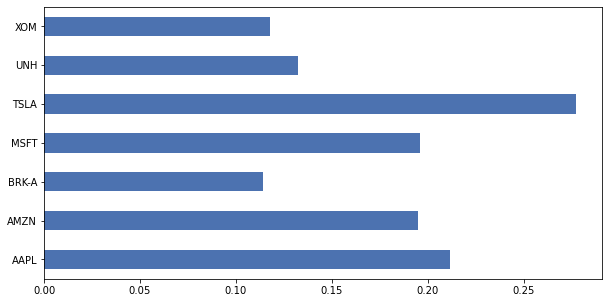

In [13]:
market_prior.plot.barh(figsize=(10,5))

### Explanation

What it just calculated was the 'market implied returns' vector (Pi), which is equal to the product of the covariance matrix of asset returns (Sigma) and a vector of weightings proportional to market cap (w_mkt), multiplied by the market-implied risk premium (delta).

Market-implied risk premium = excess return / variance

Next step: add in views vector Q and picking matrix P, which together encode all the information about our predictions.

See https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#priors for more details

## Adding Views

The model now requires us to input our predictions, all of which are either of the form 'Stock A will change by X%' or 'Stock A will outperform stock B by X%'. Due to the convenient format of Q and P, we can also set veiws of the form:
"one (normalised) linear combination of stocks, A, will outperform another, B, by X%" 
In the style of view number 4 in the example on the website.

The format of the views vector Q and picking matrix P is as follows:

Suppose we input q views, and have n assets in question. The vector Q then has q components, and P is a matrix with q rows and n columns. The format of P and Q is then such that, if we take a vector of the expected fractional return of each asset (so, with n components) and call it R, our set of views is equivalent to equating the vectors PR and Q. 

Note: if all of our views are absolute (ie, a prediction of the return of a particular asset) then we need only to put our views in a dictionary and the package will construct Q and P for us, whereas if some of our views are relative (ie, a predictions of some assets outperforming others) then we will need to construct P ourselves.

For now, I'll run an example using only absolute views, with the chance to add in relative ones later. Taking relative veiws into consideration would also imply making some assumptions about the market's return, and we want to minimise the amount of external assumptions made at this stage.

First Example: Suppose we input the following views for the 7 assets used so far:
 - AAPL will rise 20%
 - AMZN will rise 30%
 - BRK-A will rise 10%
 - TSLA will rise 20%
 - UNH will rise 10%
 - XOM will rise 60%
 
All arbitrary values, with some artifically picked to oppose priors and see what happens.
 
Note: No view is made regarding Microsoft: the example on the website didn't use views for all assets, so I'll try a similar example

Parameter changes to later investigate:

 - How long a time period should we use for our priors in order to balance making informed estimates of implied market returns and using the most relevant data to inform estimates 
 
 - The uncertainty matrix for our views (which method is best, Idzorek seems better than default)
 
 - How does changing the tau parameter affect weightings? (in some cases, it won't)

In [14]:
viewdict = {
    "AAPL": 0.2,
    "AMZN": 0.3,
    "BRK-A": 0.1,
    "TSLA": 0.2,
    "UNH": 0.1,
    "XOM": 0.6
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [15]:
#adding in confidences

confidences = [
    0.8,
    0.5,
    0.3,
    0.9,
    0.8,
    0.7
]

#could instead put 1 standard deviation intervals (so a 68% confidence interval)

In [16]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

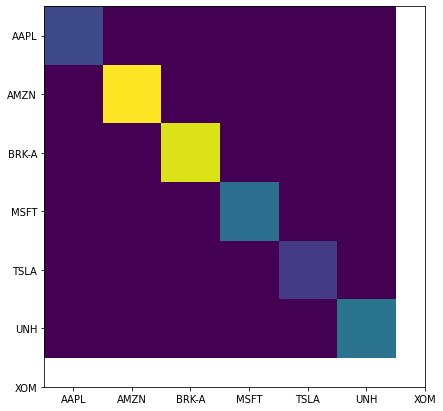

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [18]:
np.diag(bl.omega)

array([0.001384  , 0.00631815, 0.00598198, 0.00229641, 0.00111285,
       0.00243821])

### Remark on different methods for calculating omega, the uncertainty matrix for the views

Omega was just calculated using the "Idzorek" method (one of many). In the Idzorek method, the confidence for each view is taken into account (given in either percentage or interval format), so accounts directly for your chosen uncertainty for each view. It also uses Sigma, Pi, Q, P (all as defined earlier), and a risk aversion factor (like in the CAPM). Thus, it factors in both market implied returns and our view uncertainties.

If you don't specify a different argument: omega="____", then the default calculation is Omega = tau P Sigma P^T, where Sigma is again the covariance matrix used to calculate the priors, so this accounts for market implied views somewhat. Do note that if you have an absolute view for each stock (making P the identity, or something row-equivalent), then this wouldn't add much nuance to the model, and Omega could just be tau times the identity matrix.

In these two cases, the tau factor ends up cancelling out, so the value we give it doesn't matter.

## Posterior Estimates

In [19]:
omega = bl.omega

In [20]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [21]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.213314
AMZN     0.220778
BRK-A    0.170933
MSFT     0.205331
TSLA     0.215538
UNH      0.124144
XOM      0.423237
dtype: float64

In [33]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.211636,0.213314,0.2
AMZN,0.194884,0.220778,0.3
BRK-A,0.114314,0.170933,0.1
MSFT,0.196000,0.205331,NaN
TSLA,0.277023,0.215538,0.2
UNH,0.132316,0.124144,0.1
XOM,0.117559,0.423237,0.6


Remarks:

 - No view for Microsoft, with generally positive views for others, intuitively results in its posterior weighting being lower than the prior
 - The markets seem to have had a lot more faith than our analysts in Tesla in this case

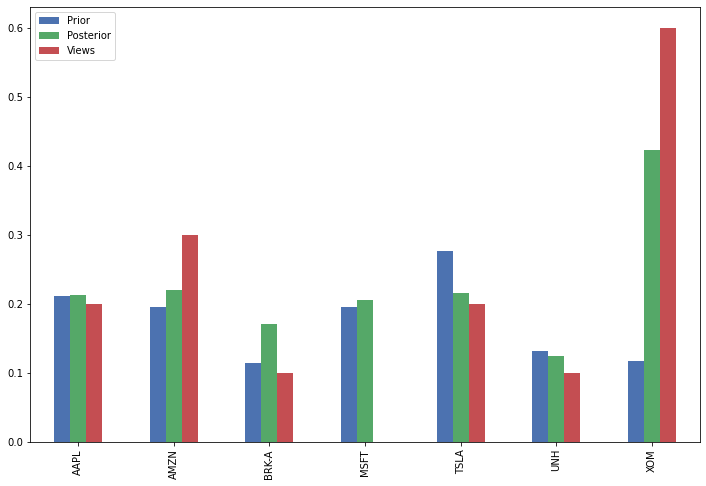

In [34]:
rets_df.plot.bar(figsize=(12,8));

## Portfolio Allocation

In [35]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\samdo\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.12925),
             ('AMZN', 0.14009),
             ('BRK-A', 0.10955),
             ('MSFT', 0.12494),
             ('TSLA', 0.09621),
             ('UNH', 0.05944),
             ('XOM', 0.34051)])

<AxesSubplot:ylabel='None'>

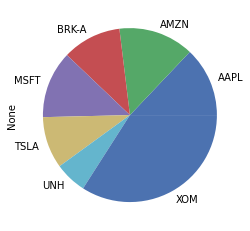

In [36]:
pd.Series(weights).plot.pie()

In [37]:
#so, say we had $15k, this is how we'd allocate it

from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=15000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $1463.24


C:\Users\samdo\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': 13, 'AMZN': 21, 'MSFT': 8, 'TSLA': 7, 'UNH': 2, 'XOM': 45}

Remarks:
 - We were not conservative enough (overly optimistic) in our view for Exxon Mobil and were punished
 - We were more conservative with our view for Tesla than the market implied returns indicate we should to be, and used a high confidence value, and so it will definitely help to input confidence values obtained from comparing our views to other analysts' views. 
 - In this case, factoring other analysts' views into our confidences would have lowered the confidence for our Tesla view, allowing market implied returns to have more influence, making our weight for Tesla less conservative, giving higher returns.
 - We didn't input a view for Microsoft, and so its weight was determined using an "expected return" which used only market-implied returns and variances as inputs. 